This notebook is for analysing a Kaggle dataset taken from this link: https://www.kaggle.com/tamber/steam-video-games.

In [1]:
# Importing standard packages for data exploration and processing.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


# Our data has no header row.
data = pd.read_csv('data/kaggle/1_steam-200k.csv', header=None)
data.head()

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       200000 non-null  int64  
 1   1       200000 non-null  object 
 2   2       200000 non-null  object 
 3   3       200000 non-null  float64
 4   4       200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [3]:
# The last column is useless and the first column is stored as integers despite being ID numbers.
data.drop(4, axis=1, inplace=True)
data[0] = data[0].astype('str')
# Current column names are not very informative, are they?
header = ['User_id', 'Game', 'Action', 'Amount']
data.columns = header
data.head()

,User_id,Game,Action,Amount
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [4]:
# Not all people that buy a game ever play it.
data['Action'].value_counts()

purchase    129511
play         70489
Name: Action, dtype: int64

In [5]:
# Is a purchase always for one game, and how many hours were played in total?
data.groupby('Action')['Amount'].sum()

Action
play        3445365.8
purchase     129511.0
Name: Amount, dtype: float64

So as we can see only 70,000 out of 200,000 actions are for playing a game while 130,000 are for purchasing a game. This means that almost a half (46% to be exact) of all games that were bought never got played. 

In [6]:
# We need to aggregate the data to a game level and get both the number of people who bought and played it.
summary = data.pivot_table(index='Game', columns='Action', values='Amount', aggfunc='count')
# And also the total amount of hours played - not actual for purchases since count = sum for them as seen above.
summary['time'] = data[data['Action'] == 'play'].groupby('Game').sum()['Amount']

summary.reset_index(inplace=True)
summary.rename_axis(None, axis=1, inplace=True)
summary.head()

,Game,play,purchase,time
0,007 Legends,1.0,1.0,0.7
1,0RBITALIS,3.0,3.0,1.2
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,5.0,7.0,20.0
3,10 Second Ninja,2.0,6.0,5.9
4,"10,000,000",1.0,1.0,3.6


In [7]:
# It would make more sense to have the 'play' columns next to each other.
summary.columns = ['Game', 'Played', 'Purchased', 'Playtime']
summary = summary[['Game', 'Purchased', 'Played', 'Playtime']]
summary.head()

,Game,Purchased,Played,Playtime
0,007 Legends,1.0,1.0,0.7
1,0RBITALIS,3.0,3.0,1.2
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7.0,5.0,20.0
3,10 Second Ninja,6.0,2.0,5.9
4,"10,000,000",1.0,1.0,3.6


In [8]:
summary.describe()

,Purchased,Played,Playtime
count,5155.000000,3600.000000,3600.000000
mean,25.123375,19.580278,957.046056
std,101.572586,104.314868,17930.737469
min,1.000000,1.000000,0.100000
25%,2.000000,1.000000,3.100000
50%,5.000000,4.000000,15.100000
75%,18.000000,12.000000,97.575000
max,4841.000000,4841.000000,981684.600000


Quite a lot of games that were bought but never played in our data, is it not? 5155 games have at least one purchase while only 3600 games have at least one person that played them. Since we are not really interested in such unpopular games, let us put some minimum qualifying restrictions. We are not going to put any restrictions on the purchases as we will not divide anything by it.

In [9]:
summary = summary[(summary['Purchased'] >= 10) & (summary['Played'] >= 5) & (summary['Playtime'] >= 100)]
summary.reset_index(drop=True, inplace=True)
# Let us also clean it up visually a bit.
summary[['Purchased', 'Played']] = summary[['Purchased', 'Played']].astype('int')

# We are also interested in how likely someone is to play a game after purchasing it and for how many hours.
# Let us call those metrics 'Conversion' and 'Dedication' accordingly.
summary['Conversion'] = summary['Played'] / summary['Purchased']
summary['Dedication'] = summary['Playtime'] / summary['Played']
summary = summary.round(2)
summary.head()

,Game,Purchased,Played,Playtime,Conversion,Dedication
0,3DMark,18,18,240.8,1.00,13.38
1,7 Days to Die,103,98,4075.5,0.95,41.59
2,A.V.A - Alliance of Valiant Arms,63,27,109.1,0.43,4.04
3,APB Reloaded,262,138,9237.2,0.53,66.94
4,ARK Survival Evolved,163,158,13593.1,0.97,86.03


In [10]:
len(summary)

778

778 games, not bad. We need to remember that the data used here is nowhere near the actual popularity of the games as it only contains 200,000 actions and is rather old. Moreover, some games might not be properly represented due to the small scale of dataset. However, we can presume that at least for the most popular games that should not be the case. And let us create a shortlist of games with stricter qualifying requirements.

In [11]:
shortlist = summary[(summary['Purchased'] >= 100) & (summary['Played'] >= 50) & (summary['Playtime'] >= 1000)]
shortlist.reset_index(drop=True, inplace=True)
shortlist.head()

,Game,Purchased,Played,Playtime,Conversion,Dedication
0,7 Days to Die,103,98,4075.5,0.95,41.59
1,APB Reloaded,262,138,9237.2,0.53,66.94
2,ARK Survival Evolved,163,158,13593.1,0.97,86.03
3,AdVenture Capitalist,222,141,6067.7,0.64,43.03
4,Age of Empires II HD Edition,238,200,6858.5,0.84,34.29


In [12]:
len(shortlist)

151

151 games, now that should be much easier to look at and analyse one by one if we need to. But let us first start by analysing the general statistics for both dataframes.

In [13]:
summary.describe()

,Purchased,Played,Playtime,Conversion,Dedication
count,778.000000,778.000000,778.000000,778.000000,778.000000
mean,111.808483,74.850900,4330.113753,0.681645,29.255463
std,237.894687,215.387606,38401.332626,0.216342,47.157791
min,10.000000,5.000000,100.300000,0.060000,1.040000
25%,29.250000,18.000000,201.850000,0.510000,8.510000
50%,57.500000,35.500000,470.650000,0.710000,15.190000
75%,114.000000,71.000000,1421.600000,0.860000,29.062500
max,4841.000000,4841.000000,981684.600000,1.000000,475.260000


Very interesting. Almost 75% of games have less than an average amount of purchases, which means that the mean is largely driven by a smaller number of very popular games. That effect stays the same for the dedication values (which, again, are measured as average time spent  and is even more pronounced for the total number of hours recorded, for which the mean is three times the 75% quantile value.

And just look at the max values for all columns. One game was purchased almost 5,000 times while we had only 130,000 purchases in our original dataset, meaning that around 3.8% of all purchases were for that one particular game - 44 times the average of our summary dataset. Interestingly, the max value for number of people who has ever played a game is exactly the same as for the number of people who bought it. Most likely, it is the same game. And since we had only 70,000 game launches in our original dataset, this game in question also accounts for around 6.9% of all game lanches - 65 times the average of our summary dataset. Similarly, some game has 228 times the mean playtime of summary dataset. Even when compared to the original dataset before eliminating less popular games, it accounts for 28.5% of all hours played! That one game alone has more playtime than the least played 75% of the games combined.

At the same time, on average only 2/3 out of all game purchases result in the person actually launching the game at least once. That is interesting because we have previously established that only 54% of all games ever get played, which is lower than our mean. The reason for such difference lies in the fact that the mean for conversion ratio takes the values for all games at an equal weight, without accounting for the different number of people who bought the game. Therefore, if many people got and did not play some specific game that would drive down the overall conversion rate significantly while not affecting the game-level mean much. Moreover, we can see that the mean conversion rate is lower than the 50% quantile value for it, and the distance between the 25% and 50% quantiles is higher than 50% and 75% quantiles. That may hint at a number of games having extremely low conversion rates and thus driving driving down the values.

Now dedication is a much more tricky subject. Not all games possess the same level of replayability to begin with, as many games are storyline-driven and intended for a certain amount of playtime. It is often multiplayer or sandbox games that can rack up a huge amount of hours played. As such, it is not really fair to compare the dedication values of different games without taking into consideration the nature of these games. For example, we could compare the dedication of players to different strategy games.

In [14]:
shortlist.describe()

,Purchased,Played,Playtime,Conversion,Dedication
count,151.000000,151.000000,151.000000,151.000000,151.000000
mean,324.721854,240.913907,18875.456954,0.724371,43.317815
std,465.970574,450.718803,85750.969927,0.188826,48.256874
min,101.000000,53.000000,1002.800000,0.180000,5.210000
25%,150.500000,109.500000,1893.600000,0.585000,15.515000
50%,214.000000,149.000000,3581.900000,0.770000,26.000000
75%,318.500000,204.000000,9058.650000,0.870000,48.845000
max,4841.000000,4841.000000,981684.600000,1.000000,310.660000


Despite further restricting our dataset we are observing the exact same behaviour as before. The means for all three main indicators (purchases, launches and total playtime) are around the 75% quantile value while the mean for playtime much exceeds it, although not as severely as before. It appears that such behaviour might be standard for any random dataset of games that we get, at the time this data was collected at least.

What is interesting is that while the most of max values stayed the same, the maximum value for dedication has dropped from 475 to 310. Apparently, some game was extremely popular among the people who bought it but did not have enough purchases or players to make it into the shortlist. Would be very interesting to take a look at that game.

In [15]:
# Top purchased.
summary.nlargest(5, 'Purchased')

,Game,Purchased,Played,Playtime,Conversion,Dedication
208,Dota 2,4841,4841,981684.6,1.00,202.79
645,Team Fortress 2,2323,2323,173673.3,1.00,74.76
731,Unturned,1563,1069,16096.4,0.68,15.06
143,Counter-Strike Global Offensive,1412,1377,322771.6,0.98,234.40
334,Half-Life 2 Lost Coast,981,177,184.4,0.18,1.04


In [16]:
# Top played.
summary.nlargest(5, 'Played')

,Game,Purchased,Played,Playtime,Conversion,Dedication
208,Dota 2,4841,4841,981684.6,1.00,202.79
645,Team Fortress 2,2323,2323,173673.3,1.00,74.76
143,Counter-Strike Global Offensive,1412,1377,322771.6,0.98,234.40
731,Unturned,1563,1069,16096.4,0.68,15.06
382,Left 4 Dead 2,951,801,33596.7,0.84,41.94


In [17]:
# Top playtime.
summary.nlargest(5, 'Playtime')

,Game,Purchased,Played,Playtime,Conversion,Dedication
208,Dota 2,4841,4841,981684.6,1.00,202.79
143,Counter-Strike Global Offensive,1412,1377,322771.6,0.98,234.40
645,Team Fortress 2,2323,2323,173673.3,1.00,74.76
140,Counter-Strike,856,568,134261.1,0.66,236.38
579,Sid Meier's Civilization V,596,554,99821.3,0.93,180.18


In [18]:
# Top played as a percentage of purchased.
summary.nlargest(5, 'Conversion')

,Game,Purchased,Played,Playtime,Conversion,Dedication
0,3DMark,18,18,240.8,1.0,13.38
9,Age of Chivalry,58,58,970.0,1.0,16.72
20,Alien Swarm,289,289,1505.0,1.0,5.21
111,Call of Juarez The Cartel,16,16,104.8,1.0,6.55
112,Car Mechanic Simulator 2015,13,13,110.6,1.0,8.51


In [19]:
# Top played by average buyer.
summary.nlargest(5, 'Dedication')

,Game,Purchased,Played,Playtime,Conversion,Dedication
53,Baldur's Gate II Enhanced Edition,17,9,4277.3,0.53,475.26
280,Football Manager 2014,80,78,30574.8,0.98,391.98
278,Football Manager 2012,80,79,30845.8,0.99,390.45
276,Football Manager 2010,38,35,13126.7,0.92,375.05
277,Football Manager 2011,34,31,11336.8,0.91,365.70


Without much surprise, the first spot for three core indicators were taken by Dota 2 which is a very much a cult game. We also have game such as 'Counter-Strike', 'Counter-Strike Global Offensive' and 'Sid Meier's Civilization V' in the tops which all look perfectly normal. 'Team Fortress 2' is also in the top of games by total playtime despite having a considerably smaller conversion rates than the rest of the top.

Three games deserve a closer look, all of which are featured in the top purchased games. 'Unturned' has a spot in both purchased and played games despite having a rather small playtime and 'Left 4 Dead 2' acts in a similar manner. At the same time, the iconic 'Half-Life 2 Lost Coast' has many purchases, relatively low conversion rate and almost no playtime. The first kind of situation is probably caused by the lack of replayability where the game is mainly storyline-driven. It is a good game, just not the one meant to be played for hundred of hours. As for 'Half-Life 2 Lost Coast', it is taken to the extreme as the game is actually a very short part of a level from the main game 'Half-Life 2'.

The top for the conversion rate is a curious one. It includes only the games for which every single person who bought them also played them, however long. Three of them appear rather niche but 'Age of Chivalry' and 'Alien Swarm' are fairly popular. And we can see in general that most of the games in the top of both number of purchases and playtime have percentages either close to 100% or around 65-70%. 

But the most interesting thing is the top for dedication. Aside from 'Baldur's Gate II Enhanced Edition' which is a very cult game, the only games we can see are different editions of 'Football Manager' franchise. What makes it so special? Is it an extreme replayability or extreme loyalty of the franchise's fanbase? Probably a bit of both, especially since we can see that almost all people who bought the game played it - so the fanbase must be pretty loyal. But also a third and very important factor. In 'Football Manager', you do not need to actively interact with the game all the time. Since you act as a team's manager, a lot of the time the game would be running in the background simulating all matches of a season until a player's intervention is necessary. That is the case for most sports management games, and a good example of why average playtime (and playtime in general) can be ill-representative of the actual popularity of the game.

Let us plot the behaviour of all indicators to show graphically the differences and similarities. Since the min and max values are very different, we are going to use logarithms. In effect, the growth of a feature's logarithm would be close enough to the rate at which that particular feature grows.

In [20]:
def plot_ascending(df):
    name = df.name
    values = df.sort_values()
    values.reset_index(drop=True, inplace=True)
    
    # Scaling the values to compare graphs with each other.
    values = (values - values.min()) / (values.max() - values.min())
    values = np.log(values + 1)
    plt.plot(values, label=name)

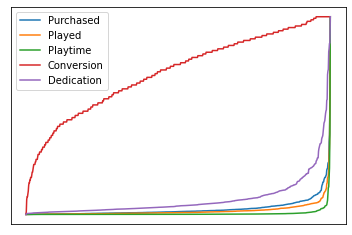

In [21]:
for column in summary.columns[1:]:
    plot_ascending(summary[column])

plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

Overall, four out of five lines seem to show a fairly similar behaviour. The growth rates for all of them are extremely skewed towards a smaller number of more popular games located on the right of the graph. That effect is the weakest for dedication, much stronger for the number of purchases, somewhat stronger for the number of players and extremely strong for the total playtime.

The conversion rate is a rather different metric so it should be no surprise. In effect, the plot is showing as the actual values for the conversion rate since they were between 0 and 1 to begin with and not much affected by the scaling. We can see that there is a group of games that are clearly less popular among their buyers but then the percentage quickly jumps and grows steadily for most of the graph. Basically, as long as you are not among those unlucky hundred games or so you are fine.

Let us better illustrate it with a plot of cumulative values. The conversion rate and the dedication are not going to be included in the next graph as it makes little sense for us to calculate the cumulative values of it. After all, they were calculated by dividing one of the three core indicators by another one and are proportions, not absolute values.

In [22]:
def plot_cumulative(df):
    name = df.name
    values = df.sort_values()
    values.reset_index(drop=True, inplace=True)
    
    # We need to both calculate the cumulative values and rescale them as proportion of total.
    values = values.cumsum()
    values = values / values.max()
    plt.plot(values, label=name)

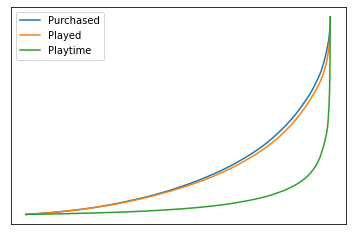

In [23]:
for column in summary.columns[1:4]:
    plot_cumulative(summary[column])

plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

Indeed, the lines look much smoother now than when we were looking at the growth rates, although the cumulative values of hours played are still heavily skewed compared to the number of purchases. Should not be too much of a surprise though, since we have already discovered before that the most played game alone accounts for 28,5% of all playtime. Now let us look at the game series created by Paradox Development Studio.

In [24]:
# Many Paradox Interactive games are in fact DLCs, which usually do not have playtime and thus are not in this list.
paradox_list = ['Europa Universalis',  'Victoria', 'Hearts of Iron', 'Crusader Kings', 'Stellaris', 'Imperator: Rome']
paradox_games = summary[summary['Game'].str.contains('|'.join(paradox_list))]
paradox_games

,Game,Purchased,Played,Playtime,Conversion,Dedication
148,Crusader Kings II,102,76,9020.7,0.75,118.69
237,Europa Universalis III,37,16,1083.0,0.43,67.69
238,Europa Universalis IV,52,50,9759.0,0.96,195.18
341,Hearts of Iron III,24,21,1203.0,0.88,57.29
737,Victoria II,19,14,575.1,0.74,41.08


Unsurprisingly, we do not have 'Stellaris' and 'Imperator: Rome' games in the list as those two games were published after this dataset was gathered. All games present in the list are around 5-10 years old at the moment when data was gathered. Their behaviour is rather interesting though. 

The conversion rates for Paradox Interactive games are above the mean value, potentially thanks to both them being sandbox games and the studio's rather loyal community. The conversion rates are generally pretty good and are at around 50% quantile ('Crusader Kings II', 'Victoria II') or 75% quantile ('Hearts of Iron III'). The 'Europa Universalis' series paints a rather different picture though, where the third game has a very low conversion rate while the fourth game has a very high one. And despite being the youngest two in the list, both 'Crusader Kings II' and 'Europa Universalis IV' have a considerably higher number of purchases and much higher playtime and dedication. The latter are especially large for 'Europa Universalis IV', which might be in part attributed to its large and active multiplayer community.

It seems overall that the either the new games in the series were very much improved or better presented to the market, probably a fair bit of both. Paradox Interactive is indeed very engaged with the community and content creators nowadays. What might more important, the studio's newer releases tend to have a cleaner gameplay system and robust tutorial, making their games much easier to get into for new players and thus driving up the sales. 'Europa Universalis' series helps support this theory as it is the only series of games on the list which has the statistics on two generations of games.

Now, there is another dimension to this data that we have not explored yet. After all, we have player IDs for all actions so we could try looking into the player's behaviour and connect it to the games they are playing. We will only look at their conversion ratios because, as discussed before, the dedication values cannot be directly compared for games of different genres.

In [25]:
# All this was done before for the games.
users = data.pivot_table(index='User_id', columns='Action', values='Amount', aggfunc='count')
users.reset_index(inplace=True)
users.rename_axis(None, axis=1, inplace=True)
users.head()

,User_id,play,purchase
0,100012061,1.0,1.0
1,100053304,6.0,7.0
2,100057229,4.0,5.0
3,100070732,4.0,7.0
4,100096071,21.0,38.0


In [26]:
# We still have some NaN values in here, in case a user never played anything.
users.fillna(0, inplace=True)
users.columns = ['User_id', 'Played', 'Purchased']
users = users[['User_id', 'Purchased', 'Played']]
users[['Purchased', 'Played']] = users[['Purchased', 'Played']].astype('int')

# Now for the conversion rates.
users['Conversion'] = users['Played'] / users['Purchased']
users = users.round(2)
users.head()

,User_id,Purchased,Played,Conversion
0,100012061,1,1,1.00
1,100053304,7,6,0.86
2,100057229,5,4,0.80
3,100070732,7,4,0.57
4,100096071,38,21,0.55


In [27]:
users.describe()

,Purchased,Played,Conversion
count,12393.000000,12393.000000,12393.000000
mean,10.450335,5.687808,0.725853
std,35.864269,17.082134,0.345081
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.500000
50%,2.000000,1.000000,1.000000
75%,6.000000,3.000000,1.000000
max,1075.000000,498.000000,1.000000


Without much surprise, we have a bunch of 0 conversion values and a lot of 1 values. This is because most users only have a few (or only one) purchases in our rather limited dataset. What if we limited the observations to those who have bought at least 5 games?

In [28]:
active_users = users[users['Purchased'] >= 5]
active_users.describe()

,Purchased,Played,Conversion
count,3761.000000,3761.000000,3761.000000
mean,30.803510,16.114065,0.547580
std,60.350906,28.362359,0.275209
min,5.000000,0.000000,0.000000
25%,7.000000,3.000000,0.330000
50%,12.000000,7.000000,0.600000
75%,27.000000,16.000000,0.770000
max,1075.000000,498.000000,1.000000


Now that is a much better picture, wtih conversion rates actually being distributed in the interval between 0 and 1. Moreover, the current mean for conversion rates matches exactly with the conversion rate of the original dataset as a whole. Also, it is interested that 1075 purchases were done by a single person, which is around 0.8% of all total purchases in our dataset. Similar thing is true for the played games. Next, let us try making a compound coefficient for each game that would account for the individual conversion rates of its users.

In [29]:
new_data = pd.merge(data, active_users[['User_id', 'Conversion']], on='User_id', how='inner')
new_data.head()

,User_id,Game,Action,Amount,Conversion
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0.65
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0.65
2,151603712,Fallout 4,purchase,1.0,0.65
3,151603712,Fallout 4,play,87.0,0.65
4,151603712,Spore,purchase,1.0,0.65


Since we cannot compare the playtime we should focus only on the conversion rates for this part of the analysis. What we want to do is reward a game more for attracting users with overall low conversion rates, because such players are less likely to play the game in question. Let us first try the adjusting coefficient of (1 / conversion rate). To this end, since we cannot divide by 0 and users with conversion rate of 0 do not really contribute anything to our artifical coefficient, let us drop such observations altogether.

In [30]:
new_data['Amount'] = np.where(new_data['Action'] == 'play', 1 / new_data['Conversion'], 1)
new_data.head()

,User_id,Game,Action,Amount,Conversion
0,151603712,The Elder Scrolls V Skyrim,purchase,1.000000,0.65
1,151603712,The Elder Scrolls V Skyrim,play,1.538462,0.65
2,151603712,Fallout 4,purchase,1.000000,0.65
3,151603712,Fallout 4,play,1.538462,0.65
4,151603712,Spore,purchase,1.000000,0.65


In [31]:
new_data.describe()

,Amount,Conversion
count,176457.000000,176457.000000
mean,1.306729,0.556313
std,0.881364,0.217697
min,1.000000,0.000000
25%,1.000000,0.410000
50%,1.000000,0.580000
75%,1.369863,0.710000
max,100.000000,1.000000


In [32]:
# All this have been done before.
coefficients = new_data.pivot_table(index='Game', columns='Action', values='Amount', aggfunc='sum')
coefficients.reset_index(inplace=True)
coefficients.columns = ['Game', 'Coefficient', 'Purchased']
coefficients = coefficients[['Game', 'Purchased', 'Coefficient']]
coefficients.rename_axis(None, axis=1, inplace=True)
coefficients['Purchased'] = coefficients['Purchased'].astype('int')

coefficients = coefficients[(coefficients['Purchased'] >= 10) & (coefficients['Coefficient'] >= 10)]
coefficients.reset_index(drop=True, inplace=True)
coefficients['Conversion'] = coefficients['Coefficient'] / coefficients['Purchased']
coefficients = coefficients.round(2)
coefficients.head()

,Game,Purchased,Coefficient,Conversion
0,100% Orange Juice,10,13.98,1.40
1,12 Labours of Hercules,10,11.99,1.20
2,12 Labours of Hercules II The Cretan Bull,12,15.47,1.29
3,140,13,16.25,1.25
4,3DMark,18,43.72,2.43


In [33]:
coefficients.describe()

,Purchased,Coefficient,Conversion
count,1312.000000,1312.000000,1312.000000
mean,70.131098,79.894558,1.140335
std,112.698228,183.332824,0.450712
min,10.000000,10.030000,0.070000
25%,19.000000,19.075000,0.800000
50%,35.000000,33.830000,1.160000
75%,71.000000,75.955000,1.480000
max,1354.000000,3638.930000,2.930000


Looks like our adjusted conversion coefficient is pretty well distributed, with mean and 50% quantile values close to 1 and 25% and 75% quantile values being equally away form 50% quantile value. Let us check the top values and plot the distribution, and also see where the Paradox Development Studio games stand.

In [34]:
# Top of adjusted conversion rates.
coefficients.nlargest(5, 'Conversion')

,Game,Purchased,Coefficient,Conversion
334,Dota 2,1243,3638.93,2.93
474,GameMaker Studio,24,61.57,2.57
4,3DMark,18,43.72,2.43
511,Grey Goo,12,28.91,2.41
725,NBA 2K16,12,27.39,2.28


<AxesSubplot:>

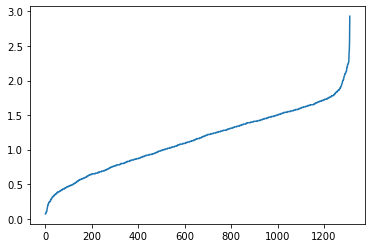

In [35]:
values = coefficients['Conversion'].sort_values()
values.reset_index(drop=True, inplace=True)
values.plot()

In [36]:
paradox_coefficients = coefficients[coefficients['Game'].str.contains('|'.join(paradox_list))]
paradox_coefficients

,Game,Purchased,Coefficient,Conversion
245,Crusader Kings II,101,139.93,1.39
387,Europa Universalis III,35,32.48,0.93
388,Europa Universalis IV,50,75.35,1.51
550,Hearts of Iron III,24,34.65,1.44
1239,Victoria II,18,23.75,1.32


Well that is interesting. You can see that the graph is almost linear except for its ends where there are big slopes. It falls in line with what we saw before, that there is a group of games with very low conversion rates - and a group of games that managed to convince low-playing users to play them. As with can see from the top, all those games seem rather niche. As for the Paradox Development Studio, its newer games tend to be closer to the 75% quantile value which is a pretty good result.